<h1>Modelling

## Modeling: Random Forest to detect hazardous NEOs

This section trains a Random Forest classifier to predict whether a Near-Earth Object (NEO) is hazardous. We'll load the final processed dataset `neo_processed.csv`, verify the target column, prepare features, split into train/test sets, fit a Random Forest, evaluate results (classification report, confusion matrix, ROC AUC), and save the trained model and feature metadata for later use.

Run cells step-by-step and inspect intermediate outputs before continuing.

In [10]:
# Load the final processed dataset
import os
import pandas as pd
FIGURE_PATH = "../Figures/"

DATA_PATH = "../Dataset/neo_processed.csv"
df_processed = pd.read_csv(DATA_PATH)
print("Loaded shape:", df_processed.shape)
df_processed.head()

Loaded shape: (39709, 45)


,sats,H,diameter,albedo,rot_per,epoch,e,a,q,i,...,rms,diameter_estimated_flag,epoch_cal,class,hazardous_label,risk_score,perihelion_ratio,eccentric_energy,uncertainty_total,observation_span_years
0,0.0,10.39,16.840000,0.250,5.270,2461000.5,0.222836,1.458121,1.133199,10.828467,...,0.29796,0.0,2025-11-21.0000000,AMO,0,0.648766,0.777164,0.072404,1.179775e-06,127.621918
1,0.0,15.59,2.736306,0.137,5.801,2461000.5,0.546596,2.636590,1.195441,11.573111,...,0.40589,1.0,2025-11-21.0000000,AMO,0,0.318619,0.453404,0.787726,4.594650e-06,113.558904
2,0.0,13.81,4.200000,0.310,28.410,2461000.5,0.571170,2.473629,1.060766,9.400060,...,0.25971,0.0,2025-11-21.0000000,AMO,0,0.908811,0.428830,0.806985,1.123263e-06,107.619178
3,0.0,9.18,37.675000,0.238,10.297,2461000.5,0.533213,2.664969,1.243972,26.680736,...,0.31447,0.0,2025-11-21.0000000,AMO,0,0.317274,0.466787,0.757694,4.382260e-07,101.046575
4,0.0,17.37,1.000000,0.137,4.400,2461000.5,0.434632,1.919831,1.085411,11.868823,...,0.40562,0.0,2025-11-21.0000000,AMO,0,0.533213,0.565368,0.362666,7.272382e-06,93.005479


In [11]:
# Check target column exists and print alternatives if not
possible_targets = ['hazardous_label', 'hazardous', 'is_hazardous', 'pha']
for t in possible_targets:
    if t in df_processed.columns:
        print(f"Found candidate target column: {t}")

# Choose hazardous_label if present, otherwise pick the first candidate found
if 'hazardous_label' in df_processed.columns:
    target_col = 'hazardous_label'
else:
    found = [c for c in possible_targets if c in df_processed.columns]
    if found:
        target_col = found[0]
        print(f"Using alternative target column: {target_col}")
    else:
        print("Available columns:\n", df_processed.columns.tolist())
        raise SystemExit("No target column found. Please ensure the processed dataset contains the target column.")

print(f"Target column selected: {target_col}")

Found candidate target column: hazardous_label
Target column selected: hazardous_label


In [12]:
# Quick EDA: class balance, missingness, dtypes
print("Target distribution:\n", df_processed[target_col].value_counts(dropna=False))
print("\nMissing values per column:\n", df_processed.isna().sum().sort_values(ascending=False).head(20))
print("\nColumn dtypes:\n", df_processed.dtypes.value_counts())

Target distribution:
 hazardous_label
0    37195
1     2514
Name: count, dtype: int64

Missing values per column:
 sats        0
H           0
diameter    0
albedo      0
rot_per     0
epoch       0
e           0
a           0
q           0
i           0
om          0
w           0
ma          0
ad          0
n           0
per         0
per_y       0
moid        0
moid_ld     0
moid_jup    0
dtype: int64

Column dtypes:
 float64    42
object      2
int64       1
Name: count, dtype: int64


In [13]:
# Prepare features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

# Drop any original/duplicate label columns if present
for c in ['pha', 'hazardous', 'is_hazardous']:
    if c in X.columns:
        X = X.drop(columns=[c])

# Fill numeric NaNs with median (safety)
num_cols = X.select_dtypes(include=['number']).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# One-hot encode categorical features (if any)
X = pd.get_dummies(X, drop_first=True)

print("Feature matrix shape after preprocessing:", X.shape)
print("Sample columns:", X.columns[:20].tolist())

Feature matrix shape after preprocessing: (39709, 4169)
Sample columns: ['sats', 'H', 'diameter', 'albedo', 'rot_per', 'epoch', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad', 'n', 'per', 'per_y', 'moid', 'moid_ld', 'moid_jup']


In [14]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))

Train shape: (31767, 4169) Test shape: (7942, 4169)
Train target distribution:
 hazardous_label
0    0.936695
1    0.063305
Name: proportion, dtype: float64
Test target distribution:
 hazardous_label
0    0.936666
1    0.063334
Name: proportion, dtype: float64



Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7439
           1       1.00      0.90      0.94       503

    accuracy                           0.99      7942
   macro avg       0.99      0.95      0.97      7942
weighted avg       0.99      0.99      0.99      7942

Confusion matrix:
 [[7437    2]
 [  52  451]]
ROC AUC: 0.9999


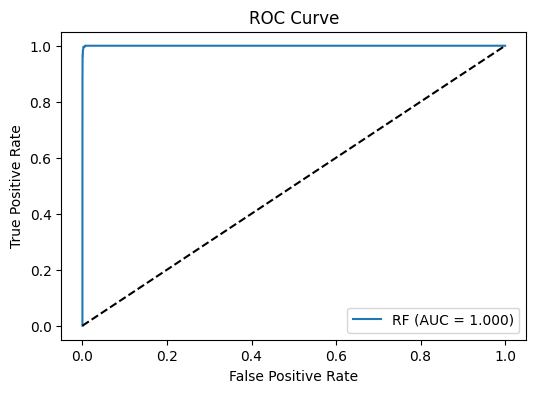


Top 15 feature importances:
risk_score: 0.1088
moid: 0.0914
moid_ld: 0.0891
H: 0.0722
diameter: 0.0685
sigma_q: 0.0291
data_arc: 0.0273
sigma_e: 0.0245
q: 0.0234
n_obs_used: 0.0217
observation_span_years: 0.0208
sigma_tp: 0.0208
sigma_i: 0.0205
sigma_a: 0.0199
uncertainty_total: 0.0198

Random Forest model saved to: c:\Users\mail2\Desktop\Boston\Sem 1\CS 506 DS\Project\CS506_Project\Notebooks\..\models\random_forest_neo.pkl


In [15]:
# Train Random Forest and evaluate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)
# Probabilities for ROC AUC - ensure binary classification
y_proba = None
if hasattr(rf, 'predict_proba') and len(y_test.unique()) == 2:
    y_proba = rf.predict_proba(X_test)[:, 1]

# Metrics
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
if y_proba is not None:
    try:
        auc = roc_auc_score(y_test, y_proba)
        print(f"ROC AUC: {auc:.4f}")
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'RF (AUC = {auc:.3f})')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.savefig(os.path.join(FIGURE_PATH, 'ROC.png'))
        plt.show()
    except Exception as e:
        print('Could not compute ROC AUC:', e)

# Feature importances (top 15)
importances = rf.feature_importances_
feat_imp = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)[:15]
print('\nTop 15 feature importances:')
for f, imp in feat_imp:
    print(f"{f}: {imp:.4f}")

# Save model and feature columns
models_dir = os.path.join(os.getcwd(), '..', 'models')
os.makedirs(models_dir, exist_ok=True)
model_path = os.path.join(models_dir, 'random_forest_neo.pkl')
joblib.dump(rf, model_path)
# Save feature list to allow consistent preprocessing when using the model
import json
with open(os.path.join(models_dir, 'rf_features.json'), 'w') as fh:
    json.dump({'features': X.columns.tolist()}, fh)

print(f"\nRandom Forest model saved to: {model_path}")

### Overfitting checks

In [16]:
# Prepare data (reuse existing objects if available)
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

if 'df_processed' not in globals():
    DATA_PATH = os.path.join('..', 'Dataset', 'neo_processed.csv')
    print('Loading dataset from', DATA_PATH)
    df_processed = pd.read_csv(DATA_PATH)
else:
    print('Using existing df_processed in memory')

possible_targets = ['hazardous_label', 'hazardous', 'is_hazardous', 'pha']
if 'target_col' not in globals():
    found = [c for c in possible_targets if c in df_processed.columns]
    if found:
        target_col = 'hazardous_label' if 'hazardous_label' in found else found[0]
    else:
        raise SystemExit('No target column found; add/set `target_col` manually')

print('Using target column:', target_col)

# Build X, y similarly to the previous preprocessing cells (safe defaults)
X = df_processed.drop(columns=[target_col]).copy()
y = df_processed[target_col].copy()

for c in ['pha', 'hazardous', 'is_hazardous']:
    if c in X.columns:
        X = X.drop(columns=[c])

# Fill numeric NaNs and one-hot encode categoricals
num_cols = X.select_dtypes(include=['number']).columns
if len(num_cols) > 0:
    X[num_cols] = X[num_cols].fillna(X[num_cols].median())
X = pd.get_dummies(X, drop_first=True)

# Ensure y is clean
if y.dtype == 'O' or y.dtype.name.startswith('str'):
    le = LabelEncoder()
    y = le.fit_transform(y.astype(str))

# Split (reproducible)
if not ('X_train' in globals() and 'X_test' in globals() and 'y_train' in globals() and 'y_test' in globals()):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Shapes — X:', X.shape, 'X_train:', X_train.shape, 'X_test:', X_test.shape)

Using existing df_processed in memory
Using target column: hazardous_label
Shapes — X: (39709, 4169) X_train: (31767, 4169) X_test: (7942, 4169)
Shapes — X: (39709, 4169) X_train: (31767, 4169) X_test: (7942, 4169)


In [17]:
# 1) Train vs Test metrics using a RandomForest baseline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np

rf_baseline = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

y_train_pred = rf_baseline.predict(X_train)
y_test_pred = rf_baseline.predict(X_test)

def report(name, y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary', zero_division=0) if len(np.unique(y_true))==2 else precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='binary', zero_division=0) if len(np.unique(y_true))==2 else recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0) if len(np.unique(y_true))==2 else f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f'--- {name} ---')
    print(f'accuracy: {acc:.4f}, precision: {prec:.4f}, recall: {rec:.4f}, f1: {f1:.4f}')
    if y_proba is not None and len(np.unique(y_true))==2:
        try:
            print('ROC AUC:', roc_auc_score(y_true, y_proba))
        except Exception:
            pass
    print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))

report('Train', y_train, y_train_pred, rf_baseline.predict_proba(X_train)[:,1] if hasattr(rf_baseline,'predict_proba') and len(np.unique(y_train))==2 else None)
report('Test', y_test, y_test_pred, rf_baseline.predict_proba(X_test)[:,1] if hasattr(rf_baseline,'predict_proba') and len(np.unique(y_test))==2 else None)

print('\nIf Train >> Test (much higher on train), that indicates overfitting.')

--- Train ---
accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000
ROC AUC: 1.0
Confusion matrix:
 [[29756     0]
 [    0  2011]]
--- Test ---
accuracy: 0.9932, precision: 0.9956, recall: 0.8966, f1: 0.9435
ROC AUC: 0.9998944363126255
Confusion matrix:
 [[7437    2]
 [  52  451]]

If Train >> Test (much higher on train), that indicates overfitting.


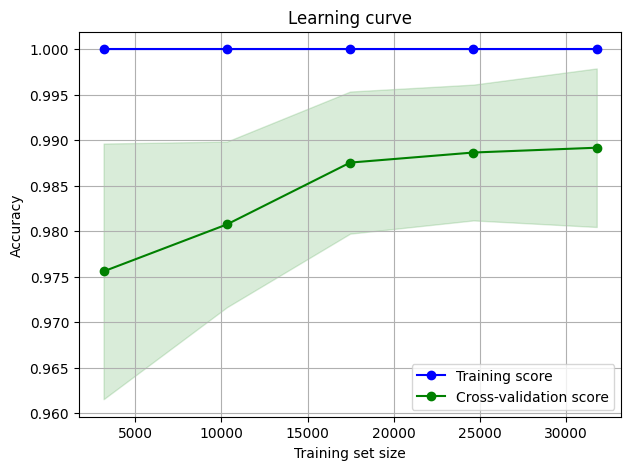

Interpretation:
- If training score is very high but validation score is much lower, the model overfits.
- If both scores are low, the model underfits.


In [18]:
# 2) Learning curve: how performance changes with more training data
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

estimator = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
train_sizes, train_scores, val_scores = learning_curve(
    estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy', n_jobs=-1, shuffle=True, random_state=42
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, 'o-', color='b', label='Training score')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.15, color='b')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.15, color='g')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning curve')
plt.legend(loc='best')
plt.grid(True)
plt.savefig(os.path.join(FIGURE_PATH, 'Learning Curve (km).png'))
plt.show()

print('Interpretation:')
print('- If training score is very high but validation score is much lower, the model overfits.')
print('- If both scores are low, the model underfits.')

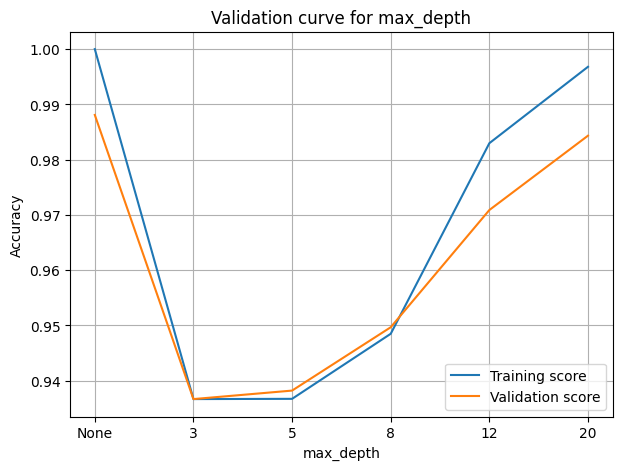

Interpretation: if training score stays high while validation score drops as complexity increases -> overfitting.


In [19]:
# 3) Validation curve: check model complexity effect (max_depth)
from sklearn.model_selection import validation_curve

param = 'max_depth'
param_range = [None, 3, 5, 8, 12, 20]

# validation_curve requires concrete parameter values; scikit-learn accepts None for max_depth but plotting uses strings
train_scores, test_scores = validation_curve(
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    X, y, param_name=param, param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(7,5))
plt.plot([str(p) for p in param_range], train_mean, label='Training score')
plt.plot([str(p) for p in param_range], test_mean, label='Validation score')
plt.xlabel(param)
plt.ylabel('Accuracy')
plt.title(f'Validation curve for {param}')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(FIGURE_PATH, 'Validation Curve.png'))
plt.show()

print('Interpretation: if training score stays high while validation score drops as complexity increases -> overfitting.')

In [17]:
# 4) OOB score for RandomForest (gives an internal CV-like estimate)
from sklearn.ensemble import RandomForestClassifier

rf_oob = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, oob_score=True)
rf_oob.fit(X_train, y_train)
if hasattr(rf_oob, 'oob_score_'):
    print('OOB score:', rf_oob.oob_score_)
else:
    print('OOB score not available for this estimator/configuration')

print('Compare OOB (approx CV) with test score to detect optimistic training.')

OOB score: 0.9940189504832059
Compare OOB (approx CV) with test score to detect optimistic training.


## Notes & next steps

- The Random Forest model was trained with default settings. Next steps:
  - Fix overfitting
  - Perform cross-validation and hyperparameter tuning (GridSearchCV / RandomizedSearchCV).
  - Try class imbalance handling if the dataset is imbalanced (class weights, SMOTE).
  - Add a preprocessing pipeline that preserves column order and exact transforms (use ColumnTransformer + Pipeline).
  - Track experiments (MLflow, Weights & Biases) and add model versioning.
  - Try Using official pha instead of self calculation